# Biodiversity Intactness vs Agricultural Land (pasture + cropland; historical)

Agricultural land is defined strictly as pasture + total cropland (from NHM data).
**NOTE**: We do NOT adjust cropland to account for the fraction used as livestock feed.
The “one third of cropland used for feed” statistic is included only as contextual
background in the figure caption and is NOT used in any calculations here.


**Data source expectation:** `./data/resource.csv` (biodiversity loss due to land use; NHM/PREDICTS-like export) with columns:  
`area_code, year, scenario, variable, value, lower_uncertainty, upper_uncertainty`.

**Outputs:**  
- The figure is **displayed inline** in the notebook.  
- The same figure is **saved** to `./output/` as both PNG and PDF.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Tuple

# ===== Unified style (one font, one canvas, consistent sizes) =====
UNIFIED_RC = {
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],   # single, reliable font to avoid OS drift
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

    "figure.dpi": 300,
    "figure.figsize": (10, 6),

    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "axes.titlepad": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.30,

    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "legend.frameon": False,

    "lines.linewidth": 2.2,
    "mathtext.fontset": "dejavusans",
}
mpl.rcParams.update(UNIFIED_RC)

def tight_layout(fig, top=0.92, bottom=0.12, left=0.10, right=0.98, wspace=0.25, hspace=0.30):
    """Compact layout helper to keep margins consistent across figures."""
    fig.subplots_adjust(top=top, bottom=bottom, left=left, right=right, wspace=wspace, hspace=hspace)

In [2]:
# ---------------- USER CONFIG ----------------
DATA_CSV   = Path("./data/resource.csv")  # biodiversity loss due to land use (NHM/PREDICTS-style)
OUTPUT_DIR = Path("./output")              # all outputs go here
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_PNG   = OUTPUT_DIR / "BII_vs_ag_land_hist_proj_LASTMARK_noYEAR.png"
OUT_PDF   = OUTPUT_DIR / "BII_vs_ag_land_hist_proj_LASTMARK_noYEAR.pdf"

# Scenarios available in the input (e.g., 'historical', 'ssp2', 'ssp3', ...)
INCLUDE_SCENARIOS = ["historical"]

# Year range subset (inclusive)
YEAR_MIN, YEAR_MAX = 1970, 2050

In [3]:
def load_data(csv_path: Path) -> pd.DataFrame:
    """Load the CSV and apply basic cleaning."""
    if not csv_path.exists():
        raise FileNotFoundError(f"Input CSV not found: {csv_path}")

    df = pd.read_csv(
        csv_path,
        usecols=["area_code","year","scenario","variable","value","lower_uncertainty","upper_uncertainty"],
        low_memory=False
    )

    # Normalize
    df["scenario"] = df["scenario"].astype(str).str.lower().str.strip()
    df["variable"] = df["variable"].astype(str).str.lower().str.strip()

    # Filter
    df = df[df["year"].between(YEAR_MIN, YEAR_MAX)]
    df = df[df["scenario"].isin([s.lower() for s in INCLUDE_SCENARIOS])].copy()

    # Validate
    required = {"area_code","year","scenario","variable","value"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")
    if df.empty:
        raise RuntimeError("After filtering, no rows remain. Check YEAR_MIN/YEAR_MAX and INCLUDE_SCENARIOS.")

    return df


def harmonize_names(wide: pd.DataFrame) -> pd.DataFrame:
    """Harmonize land-use variable names for consistency."""
    ren = {}
    for c in wide.columns:
        lc = str(c).lower()
        if lc == "pasture":  ren[c] = "pastureland"
        if lc == "cropland": ren[c] = "crops"
    wide = wide.rename(columns=ren)

    for v in ["bii", "pastureland", "crops"]:
        if v not in wide.columns:
            wide[v] = np.nan
    return wide

In [4]:
def build_series(df_scn: pd.DataFrame) -> pd.DataFrame:
    """Median-across-countries per year and convert to % (BII and ag_total)."""
    wide = df_scn.pivot_table(
        index=["area_code","year"], columns="variable", values="value", aggfunc="mean"
    ).reset_index()
    wide = harmonize_names(wide)
    wide["ag_total"] = wide[["pastureland", "crops"]].sum(axis=1)

    agg = wide.groupby("year", as_index=False)[["bii", "ag_total"]].median()

    agg["bii_pct"]      = agg["bii"] * 100.0
    agg["ag_total_pct"] = agg["ag_total"] * 100.0

    valid = agg[(agg["bii"].notna()) | (agg["ag_total"].notna())]
    if valid.empty:
        return agg.iloc[0:0].copy()
    yr_min, yr_max = int(valid["year"].min()), int(valid["year"].max())
    return agg[agg["year"].between(yr_min, yr_max)].copy()

In [14]:
from typing import Dict, Tuple

def build_all_series(df: pd.DataFrame, scenarios) -> Tuple[Dict[str, pd.DataFrame], int, int]:
    series = {}
    for scn in scenarios:
        d = df[df["scenario"] == scn]
        s = build_series(d)
        if len(s) > 0:
            series[scn] = s
    if not series:
        raise RuntimeError("No data found for the requested scenarios. Check CSV, scenarios, and variables.")
    plot_min = min(int(sdf["year"].min()) for sdf in series.values())
    plot_max = max(int(sdf["year"].max()) for sdf in series.values())
    return series, plot_min, plot_max


def plot_bii_vs_ag(series: Dict[str, pd.DataFrame], plot_min: int, plot_max: int):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    def linestyle_for(s: str) -> str:
        return "-" if s == "historical" else "--"

    for scn, agg in series.items():
        ls = linestyle_for(scn)
        ax1.plot(agg["year"], agg["bii_pct"],      color="tab:green", ls=ls, label=None)
        ax2.plot(agg["year"], agg["ag_total_pct"], color="tab:blue",  ls=ls, label=None)

    ax1.set_xlabel("Year")
    ax1.set_ylabel("Biodiversity Intactness Index (BII, %)", color="tab:green")
    ax1.tick_params(axis="y", labelcolor="tab:green")
    ax2.set_ylabel("% of land (pasture + cropland);not feed-adjusted", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    span = plot_max - plot_min
    base_step = 5 if span >= 25 else 2
    xticks = list(np.arange(plot_min, plot_max + 1, base_step))
    if plot_max not in xticks:
        xticks.append(plot_max)
    ax1.set_xlim(plot_min, plot_max)
    ax1.set_xticks(sorted(xticks))

    ax1.set_title(f"Biodiversity intactness vs agricultural land (pasture + cropland) — {plot_min}–{plot_max}")

    if "historical" in series and not series["historical"].empty:
        hist = series["historical"]
        last_y = int(hist["year"].max())
        last_pt = hist[hist["year"] == last_y]
        if not last_pt.empty and last_pt["bii_pct"].notna().all():
            ax1.scatter([float(last_pt["year"].iloc[0])],
                        [float(last_pt["bii_pct"].iloc[0])],
                        s=28, zorder=5, color="tab:green")

    handles = [
        plt.Line2D([], [], color="tab:green", lw=2.2, ls="-",  label="BII (historical)"),
        plt.Line2D([], [], color="tab:blue",  lw=2.2, ls="-",  label="Pasture+Cropland (historical)")
    ]
    ax1.legend(
        handles=handles,
        loc="upper right",
        bbox_to_anchor=(0.88, 0.98),
        bbox_transform=ax1.transAxes,
        frameon=True, facecolor="white", framealpha=0.85, edgecolor="0.85",
        ncol=1, handlelength=2.2, labelspacing=0.5
    )

    ax2.text(
        0.975, 0.50, "≈1/3 of global cropland\n used for feed-FAOSTAT(not plotted here)",
        transform=ax2.transAxes,
        rotation=90, ha="right", va="center",
        color="0.35", fontsize=10, linespacing=1.25,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.65, pad=2.0)
    )

    tight_layout(fig)
    return fig, ax1, ax2


def save_figure(fig: plt.Figure, out_png: Path, out_pdf: Path) -> None:
    out_png.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_png, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    print("Saved:", out_png)
    print("Saved:", out_pdf)

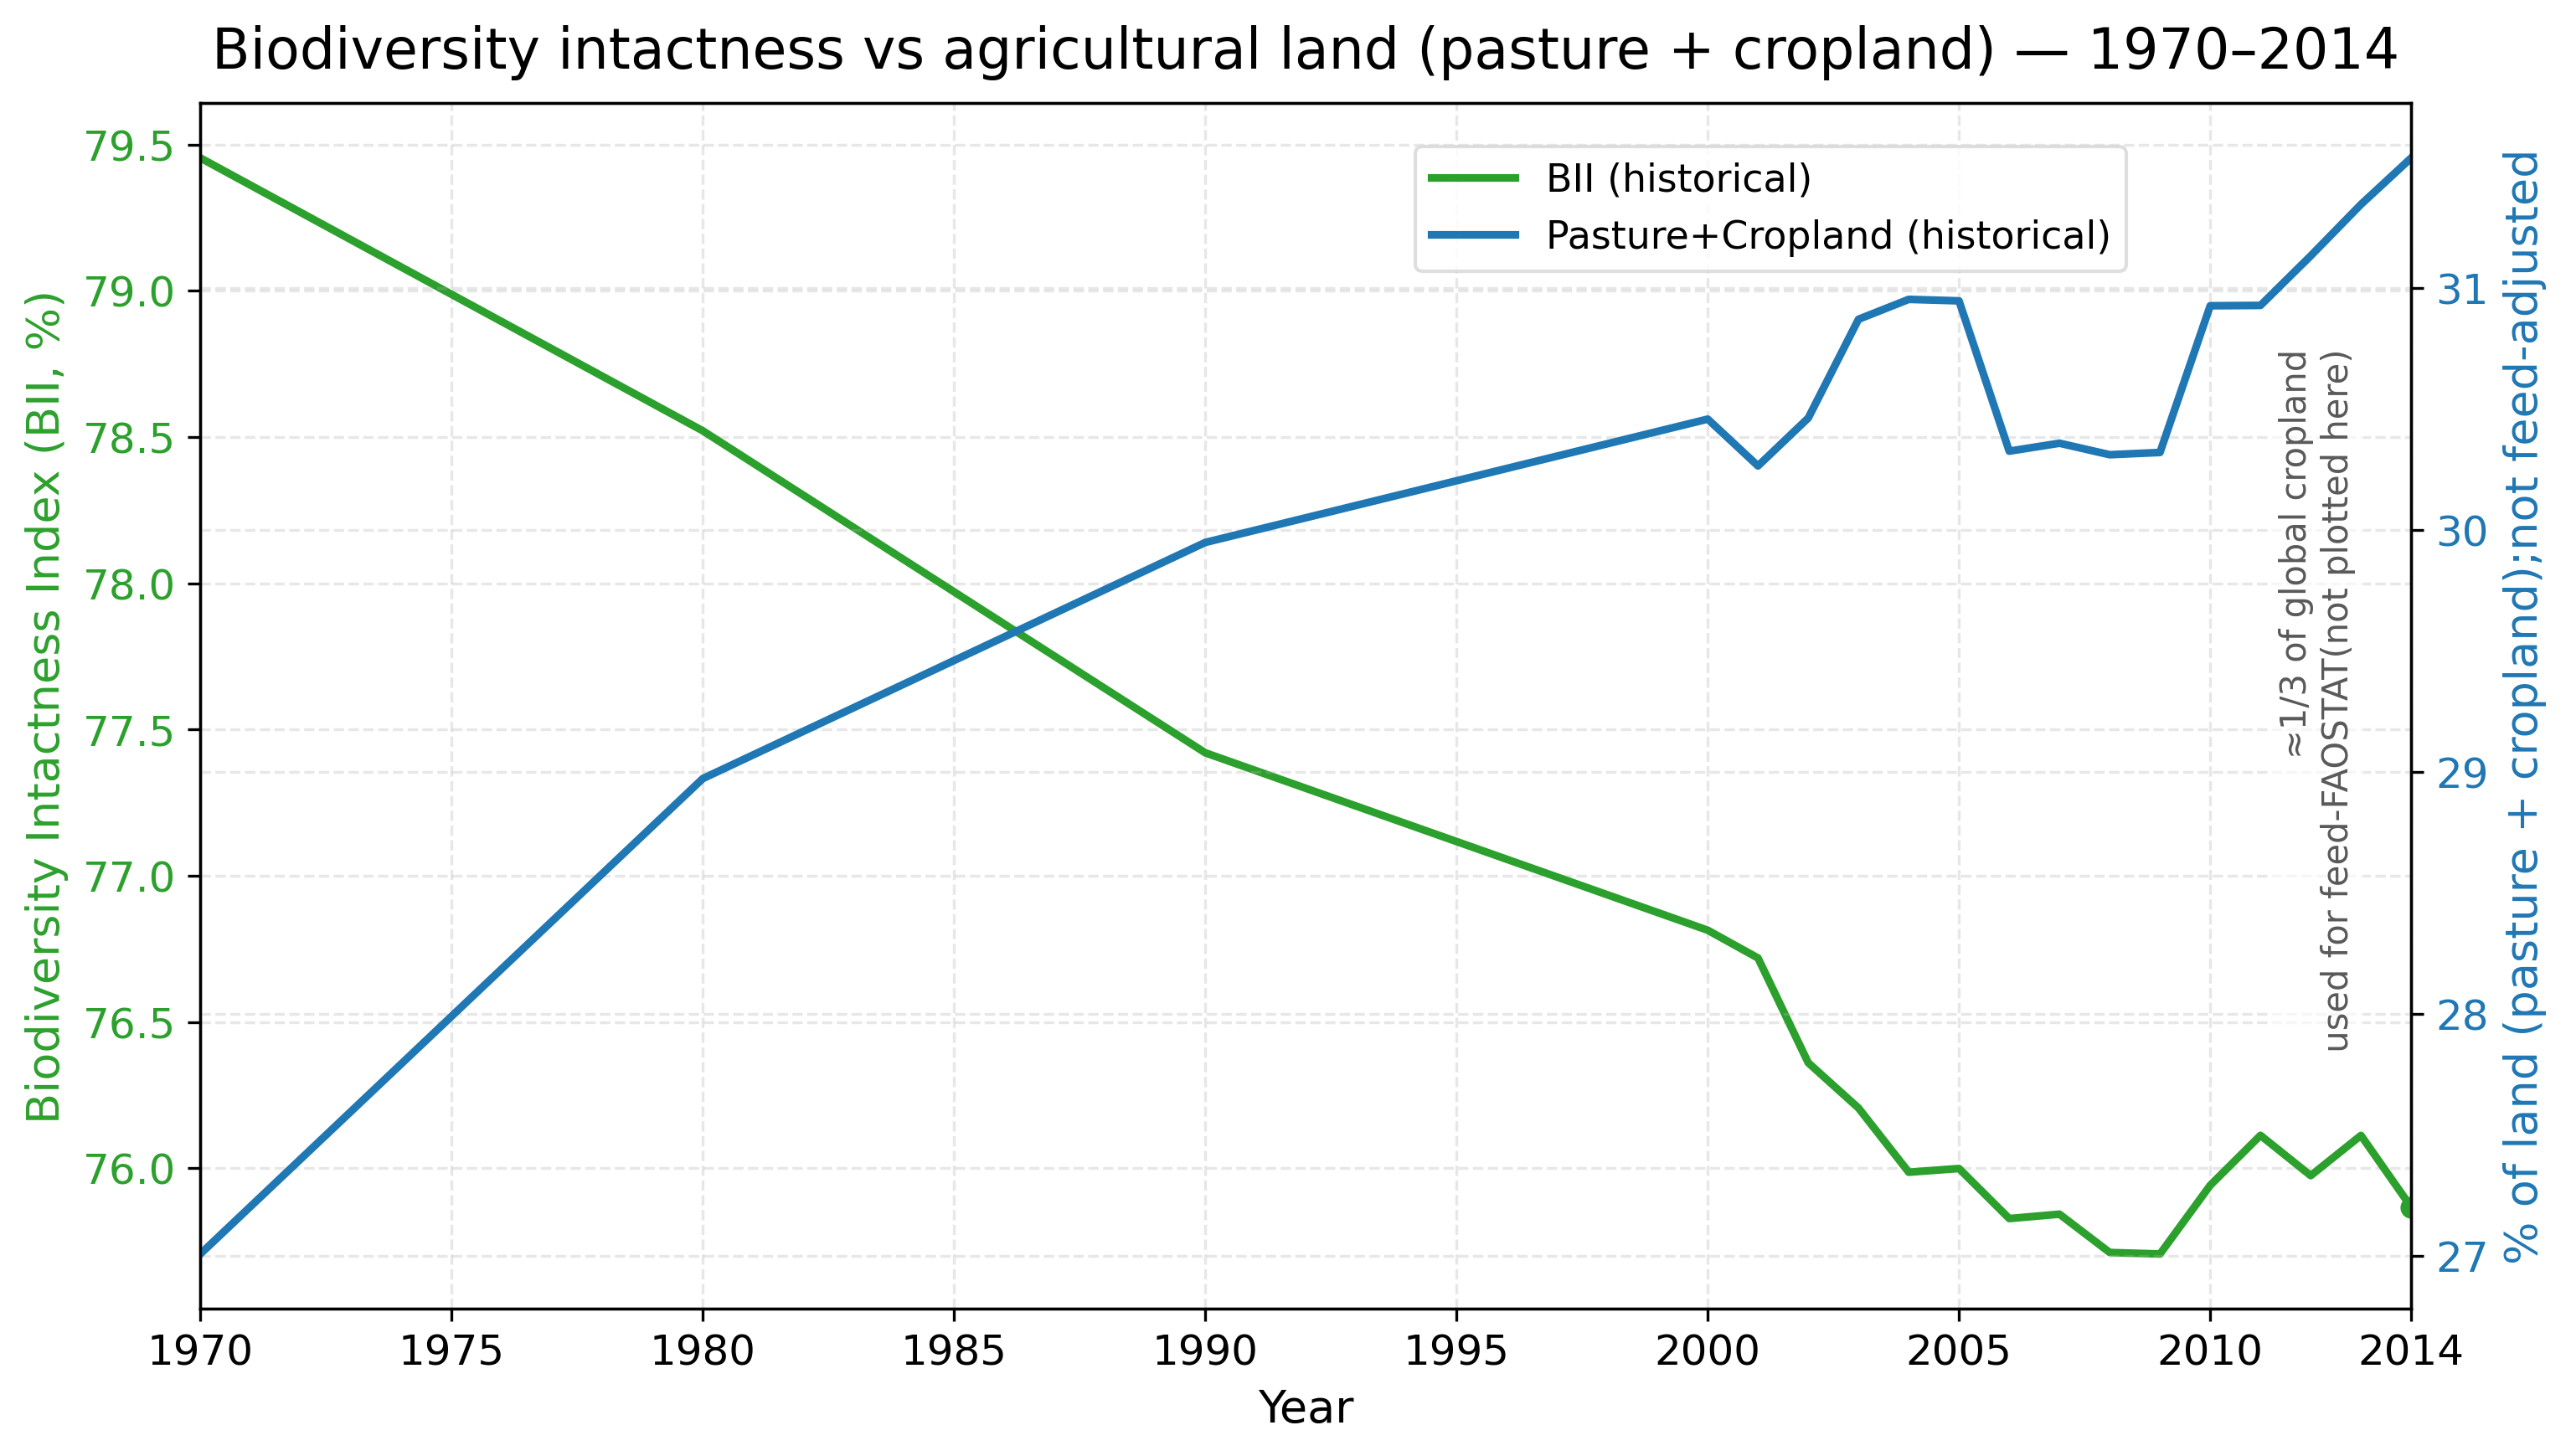

Saved: output/BII_vs_ag_land_hist_proj_LASTMARK_noYEAR.png
Saved: output/BII_vs_ag_land_hist_proj_LASTMARK_noYEAR.pdf


In [15]:
# ---------------- RUN PIPELINE ----------------
df = load_data(DATA_CSV)
series, plot_min, plot_max = build_all_series(df, INCLUDE_SCENARIOS)
fig, ax1, ax2 = plot_bii_vs_ag(series, plot_min, plot_max)

# Show inline
plt.show()

# Save to ./output/
save_figure(fig, OUT_PNG, OUT_PDF)

plt.close(fig)

## Notes & Troubleshooting

- **CSV not found**: Ensure `./data/resource.csv` exists.
- **Empty after filtering**: Verify `YEAR_MIN`, `YEAR_MAX`, and `INCLUDE_SCENARIOS`.
- **Variable names**: The loader harmonizes `pasture`→`pastureland` and `cropland`→`crops`.
- **Reusing functions**: Functions are modular and reusable in other notebooks/scripts.